# Sprint 5: Basic regression model and other basic charts


In [117]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split, cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
import zipfile
import os
import matplotlib.colors


# mounting google drive
from google.colab import drive

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Data/global diabetes.xlsx'
file_path2 = '/content/drive/MyDrive/Data/Protein_Supply_Quantity_Data.csv'
file_path3 = '/content/drive/MyDrive/Data/Healthcare-Diabetes.csv'
zip_file_path = '/content/drive/My Drive/Data/Sprint_6/States_shapefile-shp.zip'
csv_file_path = '/content/drive/My Drive/Data/Sprint_6/data-table.csv'


skip_rows = 2


Diabetes_data = pd.read_excel(file_path)
Protein_data = pd.read_csv(file_path2)
Healthcare_data = pd.read_csv(file_path3)
data_df = pd.read_csv(csv_file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

X = Healthcare_data[['Glucose', 'BloodPressure']]
X = sm.add_constant(X)
logit_model = sm.Logit(Healthcare_data['Outcome'], X)
logit_result = logit_model.fit()
print(logit_result.summary())


vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)



Optimization terminated successfully.
         Current function value: 0.526948
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                 2768
Model:                          Logit   Df Residuals:                     2765
Method:                           MLE   Df Model:                            2
Date:                Tue, 14 Nov 2023   Pseudo R-squ.:                  0.1813
Time:                        00:12:38   Log-Likelihood:                -1458.6
converged:                       True   LL-Null:                       -1781.5
Covariance Type:            nonrobust   LLR p-value:                5.753e-141
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.3025      0.258    -20.534      0.000      -5.809      -4.796
Glucose           0.

Accuracy: 93.14%
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       562
           1       0.86      0.94      0.90       269

    accuracy                           0.93       831
   macro avg       0.92      0.93      0.92       831
weighted avg       0.93      0.93      0.93       831

Confusion Matrix:
[[522  40]
 [ 17 252]]


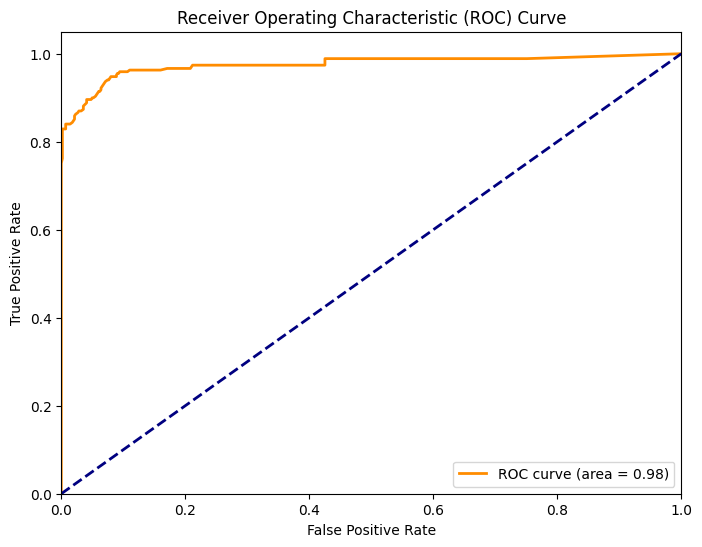

In [ ]:
X = Healthcare_data[['Glucose', 'BloodPressure']]
y = Healthcare_data['Outcome']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)
best_params = grid_search.best_params_


model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split']
)


model.fit(X_train_resampled, y_train_resampled)


y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


print(classification_report(y_test, y_pred))


conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

I need to read more about what I did here lol

Training Accuracy: 100.00%
Cross-Validation Scores:
Fold 1: 98.56%
Fold 2: 99.46%
Fold 3: 100.00%
Fold 4: 100.00%
Fold 5: 97.47%


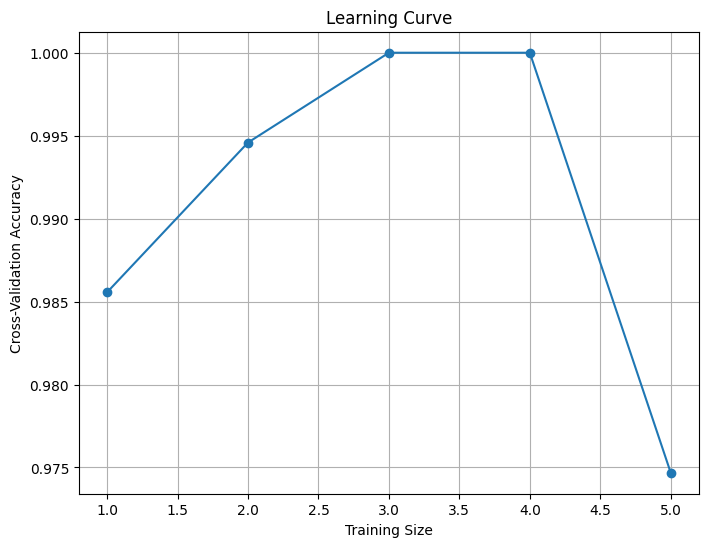

Test Accuracy: 98.38%


In [ ]:
X = Healthcare_data.drop(columns=['Outcome'])
y = Healthcare_data['Outcome']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
cv_scores = cross_val_score(model, X, y, cv=5)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print("Cross-Validation Scores:")
for fold, score in enumerate(cv_scores, 1):
    print(f"Fold {fold}: {score * 100:.2f}%")

train_sizes = range(1, len(cv_scores) + 1)
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, cv_scores, marker='o')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)
plt.show()

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

This is essentially going through my last model and seeing if I overfitted the model because it does have a very high accuracy.

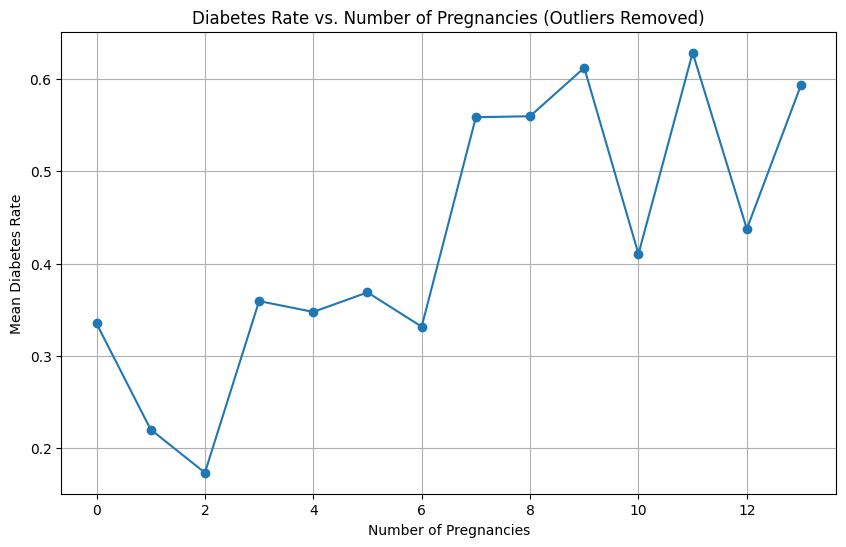

In [ ]:
Q1 = Healthcare_data['Pregnancies'].quantile(0.25)
Q3 = Healthcare_data['Pregnancies'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


filtered_data = Healthcare_data[(Healthcare_data['Pregnancies'] >= lower_bound) & (Healthcare_data['Pregnancies'] <= upper_bound)]


pregnancy_diabetes_rate = filtered_data.groupby('Pregnancies')['Outcome'].mean()


plt.figure(figsize=(10, 6))
plt.plot(pregnancy_diabetes_rate.index, pregnancy_diabetes_rate.values, marker='o')
plt.xlabel('Number of Pregnancies')
plt.ylabel('Mean Diabetes Rate')
plt.title('Diabetes Rate vs. Number of Pregnancies (Outliers Removed)')
plt.grid(True)
plt.show()

Here I decided to remove the outliers on Pregnancy column due to extremely high pregnancy numbers and found the diabetes rate by number of pregnancies

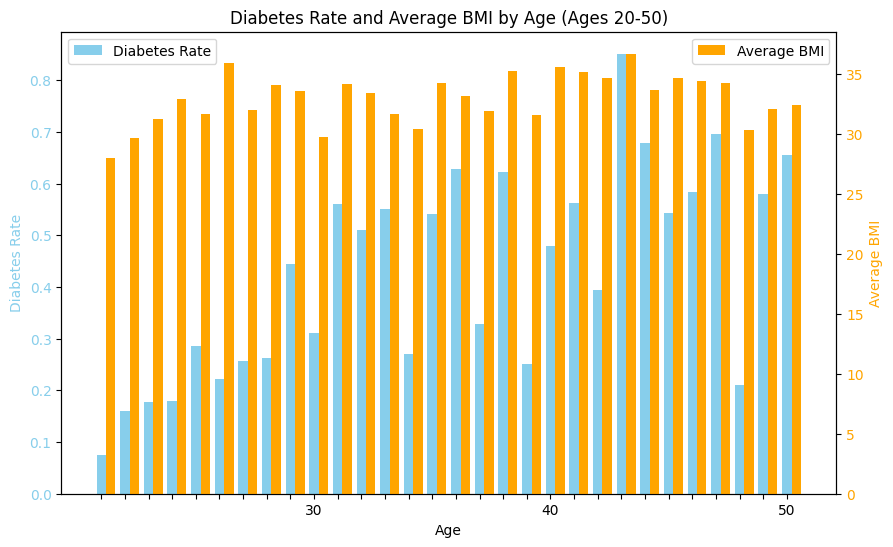

In [ ]:
filtered_data = Healthcare_data[(Healthcare_data['Age'] >= 20) & (Healthcare_data['Age'] <= 50)]


diabetes_rate_by_age = filtered_data.groupby('Age')['Outcome'].mean()

average_bmi_by_age = filtered_data.groupby('Age')['BMI'].mean()


fig, ax1 = plt.subplots(figsize=(10, 6))
bar_width = 0.4


ax1.bar(diabetes_rate_by_age.index, diabetes_rate_by_age.values, bar_width, color='skyblue', label='Diabetes Rate')
ax1.set_xlabel('Age')
ax1.set_ylabel('Diabetes Rate', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')


ax2 = ax1.twinx()


ax2.bar(average_bmi_by_age.index + bar_width, average_bmi_by_age.values, bar_width, color='orange', label='Average BMI')
ax2.set_ylabel('Average BMI', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')


x_values = diabetes_rate_by_age.index
x_labels = [str(int(x)) if int(x) % 10 == 0 else '' for x in x_values]

plt.xticks(x_values, x_labels)
plt.xticks(rotation=45)


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Diabetes Rate and Average BMI by Age (Ages 20-50)')
plt.show()

# Sprint 6: Learning to plot Cloropleth Plots (need to investigate interactive map plots once I have better RAM)

In [109]:
zip_file_path = '/content/drive/My Drive/Data/Sprint_6/States_shapefile-shp.zip'


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:

    unzipped_directory = '/tmp/unzipped_state_shapefile'
    zip_ref.extractall(unzipped_directory)

state_shapefile_path = next(
    (os.path.join(unzipped_directory, file) for file in os.listdir(unzipped_directory) if file.endswith('.shp')),
    None
)


us_states = gpd.read_file(state_shapefile_path) if state_shapefile_path else None

In [121]:
merged_gdf = us_states.merge(data_2021_df, left_on='State_Code', right_on='STATE')

# Displaying the first few rows of the merged dataset
merged_gdf_head = merged_gdf.head()

print(merged_gdf_head)

   FID          Program State_Code  State_Name Flowing_St  FID_1  \
0    1  PERMIT TRACKING         AL     ALABAMA          F    919   
1    2             None         AK      ALASKA          N    920   
2    3          AZURITE         AZ     ARIZONA          F    921   
3    4              PDS         AR    ARKANSAS          F    922   
4    5             None         CA  CALIFORNIA          N    923   

                                            geometry  YEAR STATE  RATE DEATHS  \
0  POLYGON ((-85.07007 31.98070, -85.11515 31.907...  2021    AL  26.3   1652   
1  MULTIPOLYGON (((-161.33379 58.73325, -161.3824...  2021    AK  27.0    184   
2  POLYGON ((-114.52063 33.02771, -114.55909 33.0...  2021    AZ  27.3   2559   
3  POLYGON ((-94.46169 34.19677, -94.45262 34.508...  2021    AR  39.3   1466   
4  MULTIPOLYGON (((-121.66522 38.16929, -121.7823...  2021    CA  25.5  11440   

                                        URL Mapped_STATE  
0     /nchs/pressroom/states/alabama/al.htm  

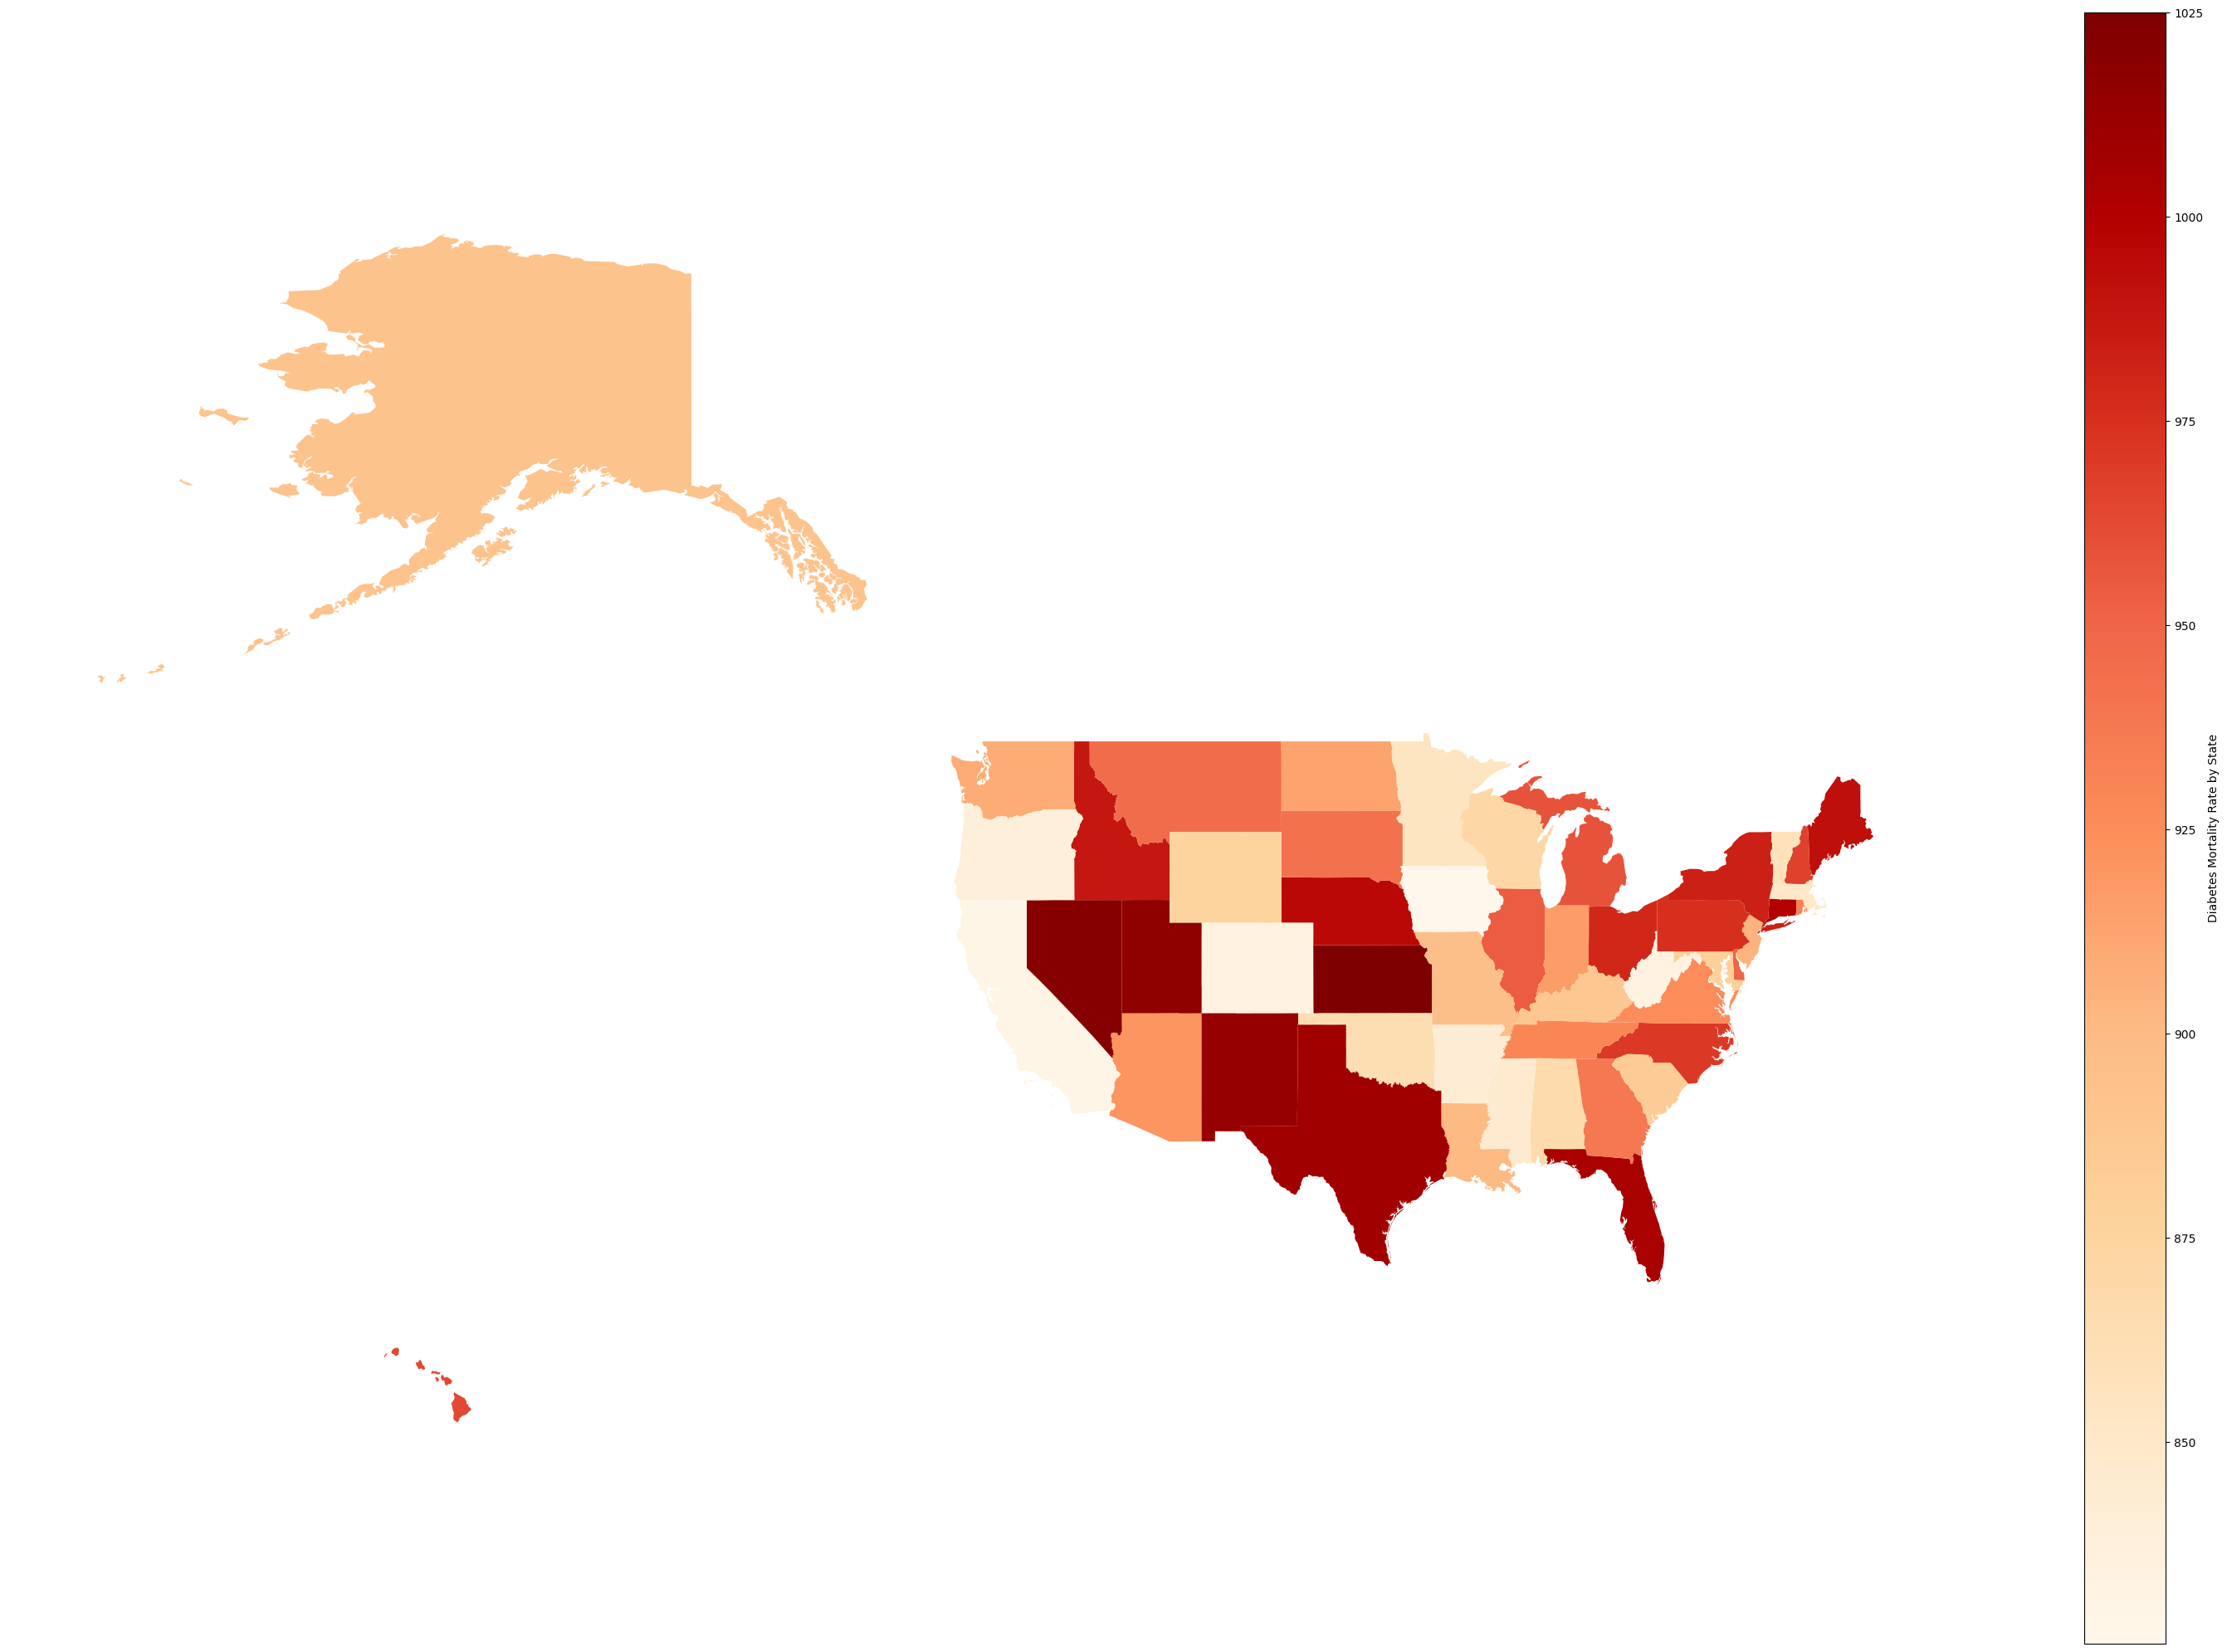

In [122]:
fig, ax = plt.subplots(1, figsize=(30, 20))

# Plotting the data without the default legend
merged_gdf.plot(column='DEATHS', ax=ax, cmap='OrRd', legend=False)

# Creating the custom colorbar
norm = matplotlib.colors.Normalize(vmin=merged_gdf['DEATHS'].min(), vmax=merged_gdf['DEATHS'].max())
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='OrRd'), ax=ax)
cbar.set_label('Diabetes Mortality Rate by State')

# Layout adjustments
plt.tight_layout()
ax.set_axis_off()

# Display the plot
plt.show()

<ipython-input-120-e85352cf96e0>:7: UserWarning:

FixedFormatter should only be used together with FixedLocator



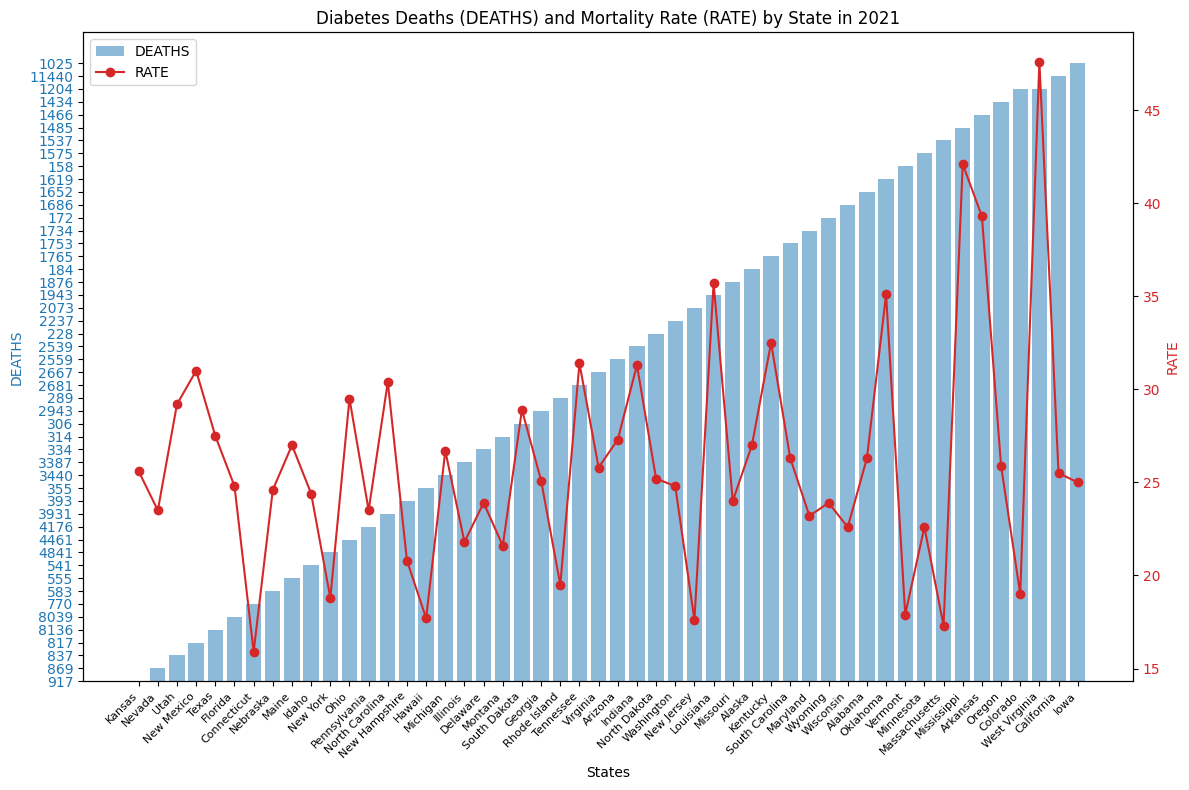

In [120]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(sorted_df['State_Name'], sorted_df['DEATHS'], color='tab:blue', alpha=0.5, label='DEATHS')
ax1.set_xlabel('States')
ax1.set_ylabel('DEATHS', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticklabels(sorted_df['State_Name'], rotation=45, ha='right', fontsize=8)


ax2 = ax1.twinx()
ax2.plot(sorted_df['State_Name'], sorted_df['RATE'], marker='o', color='tab:red', label='RATE')
ax2.set_ylabel('RATE', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

bars, bar_labels = ax1.get_legend_handles_labels()
lines, labels = ax2.get_legend_handles_labels()
ax1.legend(bars + lines, bar_labels + labels, loc='upper left')

plt.title("Diabetes Deaths (DEATHS) and Mortality Rate (RATE) by State in 2021")
plt.tight_layout()
plt.show()